In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
def logic_win(x,x_r):
    return (x >= x_r[0]) & (x < x_r[1])

def make_bins(xlim,dx):
    Edges_x = np.arange(xlim[0],xlim[1]+dx,dx)
    Bins_x = Edges_x[:-1]+dx/2
    return Edges_x,Bins_x

def ind_match(x,A):
    return np.argwhere(A == x)[:,0][0]

def find_key(Dict,item):
    for key in Dict.keys():
        if Dict[key] == item:
            return key
        else:
            return ''

#### Load in and do some cleaning

In [23]:
path = '../DataFrames/df_road_v3_zeros.csv'
df_road = pd.read_csv(path)

- this shows years of availabiliy for accidents and how many per year

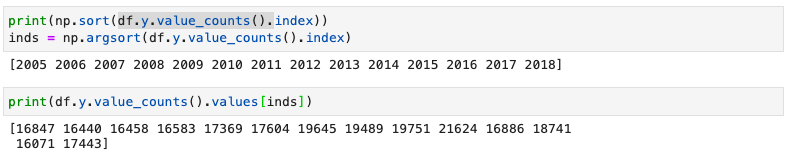

In [24]:
Ys = 2005 #must start before or on this year
Ye = 2018 #must end this year or later

Igap = df_road.Max_year_gap == 1 #we don't want gaps
Istart = df_road.Year_start <= Ys
Iend = df_road.Year_end >= Ye
Iyears = Igap & Istart & Iend

#we also only want roads with bike lanes
Iselect = df_road.bikelane & Iyears

df_road_sub = df_road.loc[Iselect,:].copy()

#### Select the features to use in clustering dataframe 
- but not neccesarily use for clustering

In [25]:
f_include = ['ID', 'total', 'slight', 'serious',
       'bikelane','aadf_Road_name', 'aadf_Road_category', 'aadf_Road_type',
       'aadf_CLT_CARR', 'aadf_CLT_SEGREG', 'aadf_CLT_STEPP', 'aadf_CLT_PARSEG',
       'aadf_CLT_SHARED', 'aadf_CLT_MANDAT', 'aadf_CLT_ADVIS',
       'aadf_CLT_PRIORI', 'aadf_CLT_CONTRA', 'aadf_CLT_BIDIRE',
       'aadf_CLT_CBYPAS', 'aadf_CLT_BBYPAS', 'aadf_CLT_PARKR',
       'aadf_CLT_WATERR', 'aadf_CLT_PTIME', 'aadf_Link_length_miles',
       'aadf_Pedal_cycles', 'aadf_All_motor_vehicles',
       'aadf_All_HGVs', 'aadf_LGVs', 'aadf_Buses_and_coaches', 'total_dnorm',
       'total_dnorm_bvnorm', 'serious_ratio','distance_to_cp']

df_cluster = df_road_sub[f_include].copy()

#make a sample length scaled total normalized to aadf_Link_length instead
LL_med = df_cluster.aadf_Link_length_miles.median()
df_cluster['total_dnorm_LL'] = df_cluster.total.values*LL_med/df_cluster.aadf_Link_length_miles.values

#### Scale the continuous data
- a question here is if this is the right way to scale the data (using the average vs. median). We have asymettric distributions with long tails out towards higher traffic

In [26]:
f_scale = ['aadf_Pedal_cycles', 'aadf_All_motor_vehicles',
       'aadf_All_HGVs', 'aadf_LGVs', 'aadf_Buses_and_coaches']

for f in f_scale:
    fname = f+'_s'
    mean = df_cluster[f].mean()
    std = df_cluster[f].std()
    #df_cluster.loc[:,f] = (df_cluster[f].values - mean)/std
    df_cluster[fname] = (df_cluster[f].values - mean)/std

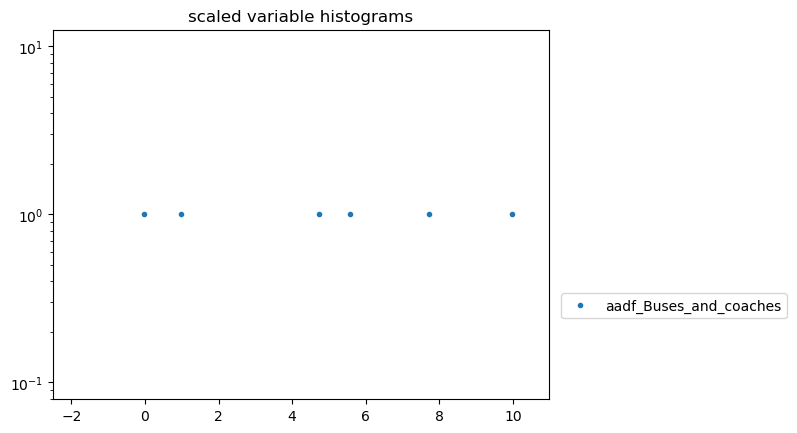

In [7]:
#histogram the scaled variables

dx = 0.05
x_r = (-10,10)
e_x,b_x = make_bins(x_r,dx)

fig,ax = plt.subplots()

f_plot = ['aadf_Buses_and_coaches']
for f in f_plot:
    H,_ = np.histogram(df_cluster[f].values,bins=e_x)
    ax.plot(b_x,H,label=f,marker='.',linestyle='none')
    
ax.set_title('scaled variable histograms')
ax.legend(bbox_to_anchor=(1.01,0.2),loc='lower left')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlim(-2.5)
plt.show()

### Goals with clustering

- Try and find clusters of roads with similar properties
- Might be good to pick subset of features for a first try (maybe ignore some of the unbanced classifiers)
- Simple accident statistics can then be calculated on these groupings. Are some better than others?
- Should probably do some cross validation on the groups that were found in the training set to see the variance of the accident statistics (we want error bars on the accident statistics)

#### Cluster 1: bikelane as only classifier

In [8]:
#print out %s of data in each classifier class

f_class = ['aadf_CLT_CARR',
       'aadf_CLT_SEGREG', 'aadf_CLT_STEPP', 'aadf_CLT_PARSEG',
       'aadf_CLT_SHARED', 'aadf_CLT_MANDAT', 'aadf_CLT_ADVIS',
       'aadf_CLT_PRIORI', 'aadf_CLT_CONTRA', 'aadf_CLT_BIDIRE',
       'aadf_CLT_CBYPAS', 'aadf_CLT_BBYPAS', 'aadf_CLT_PARKR',
       'aadf_CLT_WATERR', 'aadf_CLT_PTIME']

for f in f_class:
    print(df_cluster.loc[df_cluster.bikelane,f].value_counts(True))
    print()

True     0.833588
False    0.166412
Name: aadf_CLT_CARR, dtype: float64

False    0.756489
True     0.243511
Name: aadf_CLT_SEGREG, dtype: float64

False    0.960305
True     0.039695
Name: aadf_CLT_STEPP, dtype: float64

False    0.69542
True     0.30458
Name: aadf_CLT_PARSEG, dtype: float64

True     0.735878
False    0.264122
Name: aadf_CLT_SHARED, dtype: float64

False    0.718321
True     0.281679
Name: aadf_CLT_MANDAT, dtype: float64

True     0.587023
False    0.412977
Name: aadf_CLT_ADVIS, dtype: float64

False    0.718321
True     0.281679
Name: aadf_CLT_PRIORI, dtype: float64

False    0.773282
True     0.226718
Name: aadf_CLT_CONTRA, dtype: float64

True     0.530534
False    0.469466
Name: aadf_CLT_BIDIRE, dtype: float64

False    0.979389
True     0.020611
Name: aadf_CLT_CBYPAS, dtype: float64

False    0.975573
True     0.024427
Name: aadf_CLT_BBYPAS, dtype: float64

False    0.855725
True     0.144275
Name: aadf_CLT_PARKR, dtype: float64

False    0.975573
True     0.024

In [27]:
#pick which features to try clustering on

#intiate list with continuous variables only 
f_cluster = ['aadf_Pedal_cycles_s', 'aadf_All_motor_vehicles_s', 'aadf_All_HGVs_s',
       'aadf_LGVs_s', 'aadf_Buses_and_coaches_s']

#add in optional classifiers
f_class = []
if len(f_class) > 1:
    for f in f_class:
        f_cluster.append(f)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [28]:
ktry = np.arange(1,10+1,1).astype(int)
Nk = len(ktry)

cluster_centers = [None]*Nk
inertias = np.zeros(Nk)
Isil = ktry != 1
ksil = ktry[Isil]
Nsil = Isil.sum()
sil_scores = np.zeros(Nsil)
sm_group = np.zeros(Nsil) #smallest group by fraction
group_sizes = [None]*Nsil

ii_sil = 0
for ii,k in enumerate(ktry):
    KM = KMeans(k)
    
    KM.fit(df_cluster[f_cluster])
    cluster_centers[ii] = KM.cluster_centers_
    
    inertias[ii] = KM.inertia_
    
    if k != 1:
        clusters = KM.predict(df_cluster[f_cluster])
        sil_scores[ii_sil] = silhouette_score(df_cluster[f_cluster],clusters)
        VCs = pd.value_counts(clusters,normalize=True)
        group_sizes[ii_sil] = VCs
        sm_group[ii_sil] = VCs.min()*k #this shows % of smallest group relative to an even split
            #among groups
        ii_sil +=1

C:\Users\mccracken.96\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\mccracken.96\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\mccracken.96\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\mccracken.96\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to 

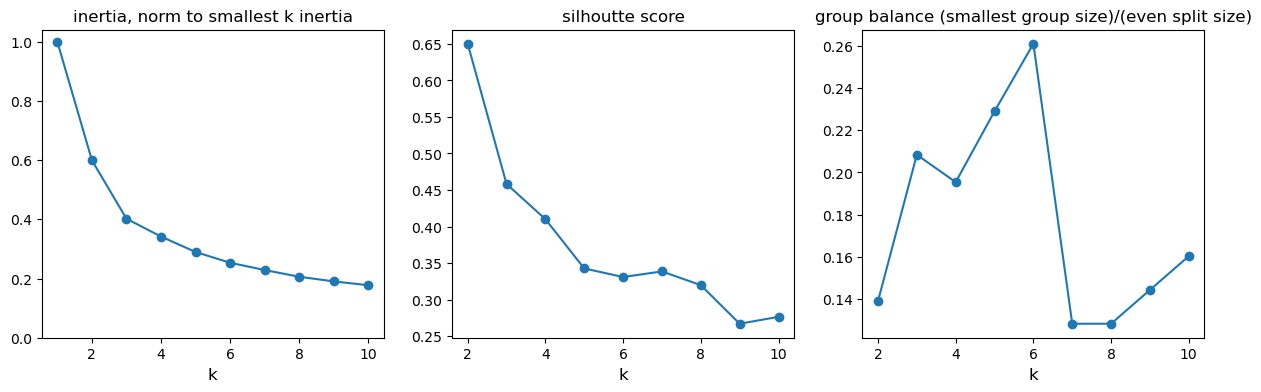

In [11]:
fig,ax = plt.subplots(1,3,figsize=(3*5,4))
labsize = 12

ii=0
ax[ii].plot(ktry,inertias/inertias[0],marker='o')
ax[ii].set_xlabel('k',fontsize=labsize)
ax[ii].set_title('inertia, norm to smallest k inertia',fontsize=labsize)
ax[ii].set_ylim(0)

ii=1
ax[ii].plot(ksil,sil_scores,marker='o')
ax[ii].set_xlabel('k',fontsize=labsize)
ax[ii].set_title('silhoutte score',fontsize=labsize)

ii=2
ax[ii].plot(ksil,sm_group,marker='o')
ax[ii].set_xlabel('k',fontsize=labsize)
ax[ii].set_title('group balance (smallest group size)/(even split size)',fontsize=labsize)

plt.show()

C:\Users\mccracken.96\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


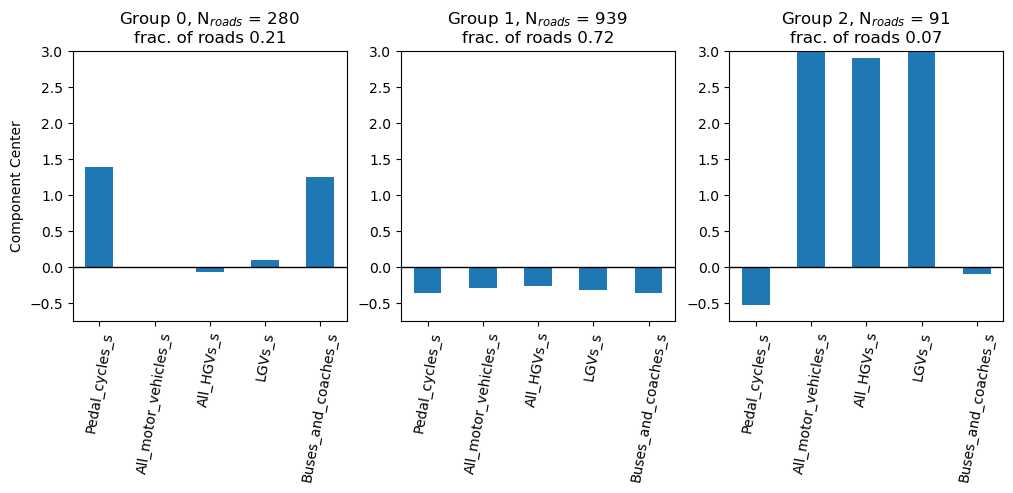

In [29]:
#make a bar plot of the cluster vectors

k = 3
ind = ind_match(k,ktry)
Nfeat_c = len(f_cluster)
Nroads = df_cluster.shape[0]

KM = KMeans(k)
KM.fit(df_cluster[f_cluster])
cluster_centers = KM.cluster_centers_
cluster_IDs = KM.predict(df_cluster[f_cluster])

ticklabs = []
for ii,f in enumerate(f_cluster):
    s = f.split('aadf_')
    if len(s) > 1:
        ticklabs.append(s[1])
    else:
        ticklabs.append(s[0])

fig,ax = plt.subplots(1,k,figsize=(k*4,3.5))
for ii in range(k):
    ii_try = ind_match(k,ktry)
    ii_sil = ind_match(k,ksil)
    
    I = cluster_IDs == ii
    n_roads_group = I.sum()
    frac_group = n_roads_group/Nroads
    
    ax[ii].bar(np.arange(Nfeat_c),cluster_centers[ii],width=0.5)
    ax[ii].set_ylim(-0.75,3)
    ax[ii].set_xticks(np.arange(Nfeat_c))
    ax[ii].set_xticklabels(ticklabs,rotation=80,fontsize=12)
    ax[ii].tick_params(labelsize=labsize)
    ax[ii].set_title('Group %i, N$_{roads}$ = %i \nfrac. of roads %.2f'%(ii,n_roads_group,
                                                                        frac_group))
    ax[ii].axhline(0,0,1,linewidth=1,color='black')
    if ii == 0:
        ax[ii].set_ylabel('Component Center',fontsize=labsize)
    
plt.show()

#### Get accident statistics for k=3 clusters

In [30]:
#calculate accident statistics for the groups
Igroup = [None]*k
for ii in range(k):
    Igroup[ii] = cluster_IDs == ii

In [31]:
#look at what peprcentage of roads have no accidents in each group

for ii in range(k):
    Izero = df_cluster.loc[Igroup[ii],'total'] == 0
    Ngroup = len(Izero)
    print('group %i zero accidents are %.2f%% of group'%(ii,100*Izero.sum()/Ngroup))

group 0 zero accidents are 0.71% of group
group 1 zero accidents are 8.52% of group
group 2 zero accidents are 29.67% of group


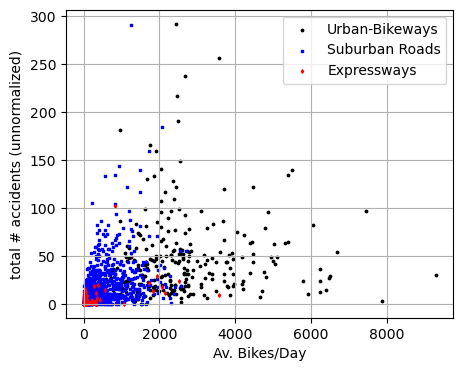

In [32]:
#make scatter plot of total vs. aadf_Bike_volume, hue based on group

msize = 3
group_c = {0:'black',1:'blue',2:'red'}
group_m = {0:'o',1:'s',2:'d'}
group_size = {0:msize,1:msize,2:msize}
group_order = [0,1,2] #order to plot in 
group_names = {0:'Urban-Bikeways',1:'Suburban Roads',2:'Expressways'}

fig,ax = plt.subplots(figsize=(5,4))
labsize=10
ticksize=10
legsize=10

for g in group_order:
    ig = ind_match(g,np.arange(k).astype(int))
    ax.scatter(df_cluster.loc[Igroup[ig],'aadf_Pedal_cycles'],df_cluster.loc[Igroup[ig],'total'],marker=group_m[g],color=group_c[g],
              label=group_names[g],s=group_size[g])
    
ax.set_xlabel('Av. Bikes/Day',fontsize=labsize)
ax.set_ylabel('total # accidents (unnormalized)',fontsize=labsize)
ax.tick_params(labelsize=ticksize)
ax.legend(fontsize=legsize)
ax.grid('on')
plt.show()

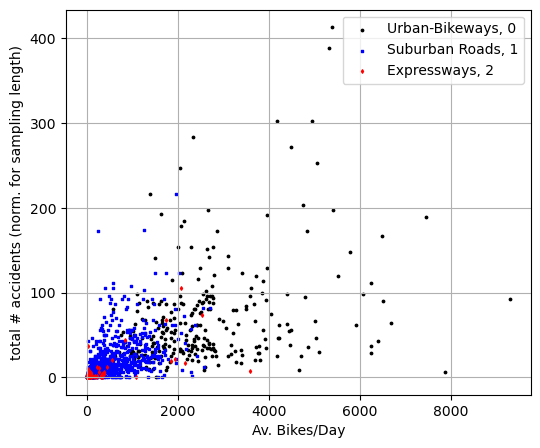

In [33]:
#make scatter plot of total vs. aadf_Bike_volume, hue based on group

# msize = 3
# group_c = {0:'blue',1:'red',2:'black'}
# group_m = {0:'o',1:'s',2:'d'}
# group_size = {0:msize,1:msize,2:msize}
# group_order = [0,2,1] #order to plot in 
# group_names = {0:'Suburban Roads',1:'Expressways',2:'Urban-Bikeways'}

fy = 'total_dnorm_LL' #you can use total_dnorm alternatively, this is normalized to av. "distance_to_cp". Problem is, that feature is undefined when there is 0 accidents

fig,ax = plt.subplots(figsize=(6,5))
labsize=10
ticksize=10
legsize=10

for g in group_order:
    ig = ind_match(g,np.arange(k).astype(int))
    ax.scatter(df_cluster.loc[Igroup[ig],'aadf_Pedal_cycles'],df_cluster.loc[Igroup[ig],fy],marker=group_m[g],color=group_c[g],
              label='%s, %i'%(group_names[g],g),s=group_size[g])
    
ax.set_xlabel('Av. Bikes/Day',fontsize=labsize)
ax.set_ylabel('total # accidents (norm. for sampling length)',fontsize=labsize)
ax.tick_params(labelsize=ticksize)
ax.legend(fontsize=legsize)
ax.grid('on')
plt.show()

C:\Users\mccracken.96\AppData\Local\Temp\1\ipykernel_32\1468950671.py:15: RuntimeWarning: invalid value encountered in divide
  H_tot_dnorm_bv[ii] = H_tot/H


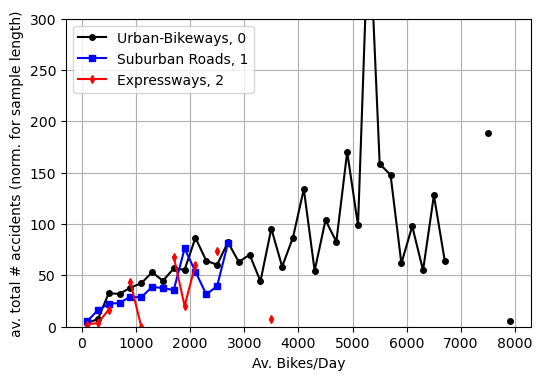

In [34]:
#Make av. total_dnorm vs. bike volume histograms for groups and plot

dbv = 200
bv_r = (0,8000)
e_bv,b_bv = make_bins(bv_r,dbv)
Nbv = len(b_bv)

fy = 'total_dnorm_LL'

H_tot_dnorm_bv = np.zeros((k,Nbv))
for ii in range(k):
    I = Igroup[ii]
    H,_ = np.histogram(df_cluster.loc[I,'aadf_Pedal_cycles'],bins=e_bv)
    H_tot,_ = np.histogram(df_cluster.loc[I,'aadf_Pedal_cycles'],bins=e_bv,weights=df_cluster.loc[I,fy])
    H_tot_dnorm_bv[ii] = H_tot/H
    
gname_plt = ['Urban-Bikeways','Suburban Roads','Expressways']
g_plt = []
for n in gname_plt:
    for key in group_names.keys():
        if group_names[key] == n:
            g_plt.append(key)

fig,ax = plt.subplots(figsize=(6,4))
labsize=10
ticksize=10
legsize=10
                      
for g in g_plt:
    ig = ind_match(g,np.arange(k).astype(int))
    ax.plot(b_bv,H_tot_dnorm_bv[g],marker=group_m[g],color=group_c[g],
              label='%s, %i'%(group_names[g],g),markersize=4)
    
ax.set_xlabel('Av. Bikes/Day',fontsize=labsize)
ax.set_ylabel('av. total # accidents (norm. for sample length)',fontsize=labsize)
ax.tick_params(labelsize=ticksize)
ax.legend(fontsize=legsize)
ax.set_ylim(0,300)
ax.grid('on')
plt.show()                      

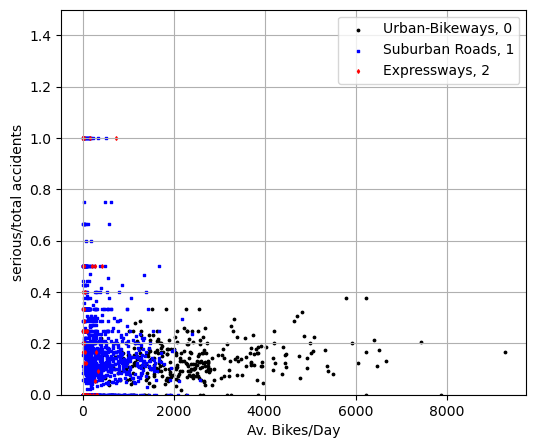

In [27]:
#scatter plot of serious ratio vs. Av. Bike/Day

fy = 'serious_ratio' #you can use total_dnorm alternatively, this is normalized to av. "distance_to_cp". Problem is, that feature is undefined when there is 0 accidents

fig,ax = plt.subplots(figsize=(6,5))
labsize=10
ticksize=10
legsize=10

for g in group_order:
    ig = ind_match(g,np.arange(k).astype(int))
    ax.scatter(df_cluster.loc[Igroup[ig],'aadf_Pedal_cycles'],df_cluster.loc[Igroup[ig],fy],marker=group_m[g],color=group_c[g],
              label='%s, %i'%(group_names[g],g),s=group_size[g])
    
ax.set_xlabel('Av. Bikes/Day',fontsize=labsize)
ax.set_ylabel('serious/total accidents',fontsize=labsize)
ax.tick_params(labelsize=ticksize)
ax.legend(fontsize=legsize)
ax.grid('on')
ax.set_ylim(0)
plt.show()

C:\Users\mccracken.96\AppData\Local\Temp\1\ipykernel_6108\1988455227.py:17: RuntimeWarning: invalid value encountered in divide
  H_tot_dnorm_bv[ii] = H_tot/H


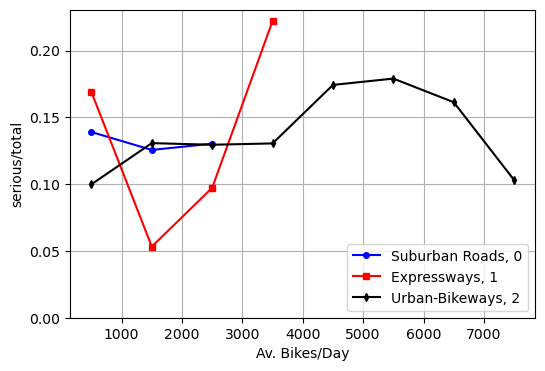

In [36]:
#Make av. total_dnorm vs. bike volume histograms for groups and plot

####THIS IS NOT THE BEST WAY TO DO THIS, USE BELOW INSTEAD#########

dbv = 1000
bv_r = (0,8000)
e_bv,b_bv = make_bins(bv_r,dbv)
Nbv = len(b_bv)

fy = 'serious_ratio'

Inan = df_cluster.serious_ratio == -9

H_tot_dnorm_bv = np.zeros((k,Nbv))
for ii in range(k):
    I = Igroup[ii] & ~Inan
    H,_ = np.histogram(df_cluster.loc[I,'aadf_Pedal_cycles'],bins=e_bv)
    H_tot,_ = np.histogram(df_cluster.loc[I,'aadf_Pedal_cycles'],bins=e_bv,weights=df_cluster.loc[I,fy])
    H_tot_dnorm_bv[ii] = H_tot/H
    
g_plt = [0,1,2]
fig,ax = plt.subplots(figsize=(6,4))
labsize=10
ticksize=10
legsize=10
                      
for g in g_plt:
    ig = ind_match(g,np.arange(k).astype(int))
    ax.plot(b_bv,H_tot_dnorm_bv[g],marker=group_m[g],color=group_c[g],
              label='%s, %i'%(group_names[g],g),markersize=4)
    
ax.set_xlabel('Av. Bikes/Day',fontsize=labsize)
ax.set_ylabel('serious/total',fontsize=labsize)
ax.tick_params(labelsize=ticksize)
ax.legend(fontsize=legsize)
ax.set_ylim(0)
ax.grid('on')
plt.show()  

In [35]:
#Do same as above except calculate the serious ratio after binning (so weighted bin serious and total separately)

dbv = 1000
bv_r = (0,8000)
e_bv,b_bv = make_bins(bv_r,dbv)
Nbv = len(b_bv)

fy1 = 'serious'
fy2 = 'total'
fnorm = 'aadf_Link_length_miles'
Lmed = df_cluster[fnorm].median()

Inan = df_cluster.serious_ratio == -9

H1 = np.zeros((k,Nbv))
H2 = np.zeros((k,Nbv))
H_ser_rat_bv = np.zeros((k,Nbv))
H_road = np.zeros((k,Nbv))
for ii in range(k):
    I = Igroup[ii] & ~Inan
    H_road[ii],_ = np.histogram(df_cluster.loc[I,'aadf_Pedal_cycles'],bins=e_bv)
    H1[ii],_ = np.histogram(df_cluster.loc[I,'aadf_Pedal_cycles'].values,bins=e_bv,weights=df_cluster.loc[I,fy1].values*Lmed/df_cluster.loc[I,fnorm].values)
    H2[ii],_ = np.histogram(df_cluster.loc[I,'aadf_Pedal_cycles'].values,bins=e_bv,weights=df_cluster.loc[I,fy2].values*Lmed/df_cluster.loc[I,fnorm].values)
    H_ser_rat_bv[ii] = H1[ii]/H2[ii]
    
# g_plt = [0,1,2]
# fig,ax = plt.subplots(figsize=(6,4))
# labsize=10
# ticksize=10
# legsize=10
                      
# for g in g_plt:
#     ig = ind_match(g,np.arange(k).astype(int))
#     ax.plot(b_bv,H_ser_rat_bv[g],marker=group_m[g],color=group_c[g],
#               label='%s, %i'%(group_names[g],g),markersize=4)
    
# ax.set_xlabel('Av. Bikes/Day',fontsize=labsize)
# ax.set_ylabel('serious/total',fontsize=labsize)
# ax.tick_params(labelsize=ticksize)
# ax.legend(fontsize=legsize)
# ax.set_ylim(0)
# ax.grid('on')
# plt.show()  


# fig,ax = plt.subplots(figsize=(6,4))
# labsize=10
# ticksize=10
# legsize=10
                      
# for g in g_plt:
#     ig = ind_match(g,np.arange(k).astype(int))
#     ax.plot(b_bv,H_road[g],marker=group_m[g],color=group_c[g],
#               label='%s, %i'%(group_names[g],g),markersize=4)
    
# ax.set_xlabel('Av. Bikes/Day',fontsize=labsize)
# ax.set_ylabel('# of roads',fontsize=labsize)
# ax.tick_params(labelsize=ticksize)
# ax.legend(fontsize=legsize)
# ax.set_ylim(1)
# ax.set_yscale('log')
# ax.grid('on',which='both')
# plt.show()  

C:\Users\mccracken.96\AppData\Local\Temp\1\ipykernel_32\247752062.py:24: RuntimeWarning: invalid value encountered in divide
  H_ser_rat_bv[ii] = H1[ii]/H2[ii]


C:\Users\mccracken.96\AppData\Local\Temp\1\ipykernel_32\430739090.py:30: RuntimeWarning: invalid value encountered in divide
  H_err_ratio[ii] = H_ser_rat_bv[ii]*np.sqrt((H_err_A[ii]/H1[ii])**2 + (H_err_B[ii]/H2[ii])**2 - 2*p_AB*H_err_A[ii]*H_err_B[ii]/(H1[ii]*H2[ii]))


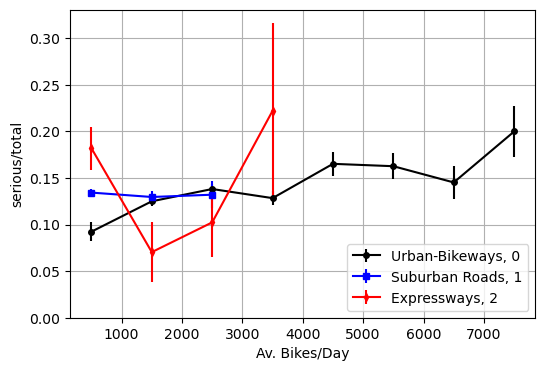

In [36]:
#get errorbars for serious ratio histograms

#need to find errors for each bin
#-find roads that fit in each bin for both A and B (A=ser/norm B = total/norm)
#-for each bin take the quadrature sum of errors, assuming the error is Poisson
#now with the binned erorrs for A and B calculate the serious ratio errors via propagation of error

H_err_A = np.zeros((k,Nbv))
H_err_B = np.zeros((k,Nbv))
fx = 'aadf_Pedal_cycles'

for ii in range(k):
    Ig = Igroup[ii] & ~Inan
    for jj in range(Nbv):
        bin_r = (e_bv[jj],e_bv[jj+1])
        Ibv = logic_win(df_cluster[fx].values,bin_r)
        I = Ibv & Ig #these are the entries that belong in this bin
        if I.sum() > 0:
            errs_A = np.sqrt(df_cluster.loc[I,fy1].values)*Lmed/df_cluster.loc[I,fnorm].values
            errs_B = np.sqrt(df_cluster.loc[I,fy2].values)*Lmed/df_cluster.loc[I,fnorm].values
            H_err_A[ii,jj] = np.sqrt(np.sum(errs_A**2))
            H_err_B[ii,jj] = np.sqrt(np.sum(errs_B**2))
            
#calculate correlation between serious and total (no need to norm)
calc_corr = df_cluster[['total','serious']].corr()['total']['serious']
            
H_err_ratio = np.zeros((k,Nbv))
p_AB = calc_corr #correlation between A and B
for ii in range(k):
    H_err_ratio[ii] = H_ser_rat_bv[ii]*np.sqrt((H_err_A[ii]/H1[ii])**2 + (H_err_B[ii]/H2[ii])**2 - 2*p_AB*H_err_A[ii]*H_err_B[ii]/(H1[ii]*H2[ii]))
    
g_plt = [0,1,2]
fig,ax = plt.subplots(figsize=(6,4))
labsize=10
ticksize=10
legsize=10
                      
for g in g_plt:
    ig = ind_match(g,np.arange(k).astype(int))
    ax.errorbar(b_bv,H_ser_rat_bv[g],H_err_ratio[g],marker=group_m[g],color=group_c[g],
              label='%s, %i'%(group_names[g],g),markersize=4)
    
ax.set_xlabel('Av. Bikes/Day',fontsize=labsize)
ax.set_ylabel('serious/total',fontsize=labsize)
ax.tick_params(labelsize=ticksize)
ax.legend(fontsize=legsize,loc='lower right')
ax.set_ylim(0)
ax.grid('on')
plt.show()  

#### Estimate error in link-length for urban-bikeways cluster
- do this by comparing averaged "distance_to_cp" to link_length
- if we take averaged "distance_to_cp" as close to true value of sampling length, then we can calculate standard deviation
- $\sigma^{2}$ = $\frac{1}{N}{\Sigma}(LL - d2cp_{av})^{2}$

In [41]:
find_key

<function __main__.find_key(Dict, item)>

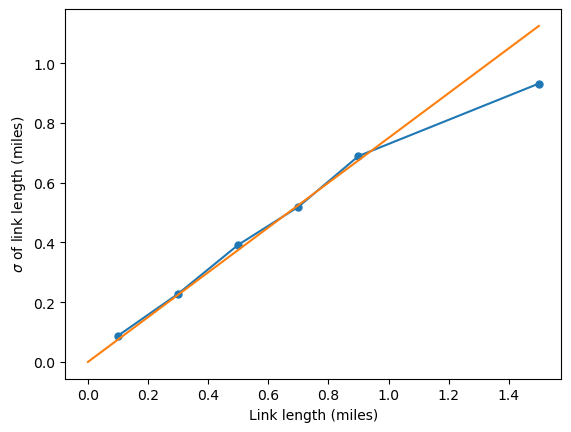

LL-total corr = 0.62


In [87]:
#calculate sigma^2 for urban cluster across whole set

gk = find_key(group_names,'Urban-Bikeways')
Iacc = df_cluster.total >= 20
I = Iacc & Igroup[gk]

sigma_LL_urb_all = np.sqrt(1/I.sum()*np.sum(np.power(df_cluster.loc[I,'aadf_Link_length_miles'].values-df_cluster.loc[I,'distance_to_cp'].values,2)))

#calculate sigma vs. LL

LL_r = (0,1)
dLL = 0.2
e_LL,b_LL = make_bins(LL_r,dLL)
e_LL = np.concatenate([e_LL,[2]]) #make large bin for 1-2 miles data
b_LL = np.concatenate([b_LL,[1.5]])
Nb_LL = len(b_LL)

b = 0.75
xplt = np.linspace(0,1.5,10)
yplt = b*xplt

fx = 'aadf_Link_length_miles'
sigma_LL_urb = np.zeros(Nb_LL)
for ii in range(Nb_LL):
    Ibin = logic_win(df_cluster[fx].values,(e_LL[ii],e_LL[ii+1]))
    I = Ibin & Igroup[gk] & Iacc
    sigma_LL_urb[ii] = np.sqrt(1/I.sum()*np.sum(np.power(df_cluster.loc[I,'aadf_Link_length_miles'].values-df_cluster.loc[I,'distance_to_cp'].values,2)))
    
plt.plot(b_LL,sigma_LL_urb,marker='.',markersize=10)
plt.xlabel('Link length (miles)')
plt.ylabel('$\sigma$ of link length (miles)')
plt.plot(xplt,yplt)
plt.show()

#finally, calculate pearson corr. for LL and total
f1 = 'aadf_Link_length_miles'
f2 = 'total'
p_LL_tot_urb = df_cluster.loc[Iacc&Igroup[gk],[f1,f2]].corr()[f1][f2]
print('LL-total corr = %.2f'%p_LL_tot_urb)

#### Look at shared vs. unshared bikelanes in the urban group
- need to make errorbars for below plot
- error is sigma_H_tot[ii]/[H] fpr each bin ii
- need to recalculate distance normalized totals for this to get error

C:\Users\mccracken.96\AppData\Local\Temp\1\ipykernel_32\462121814.py:50: RuntimeWarning: invalid value encountered in divide
  H_err[ii,jj] = Lmed/N*np.sqrt(np.sum( ((quants/norms)**2)*((sig_quants/quants)**2 +\
C:\Users\mccracken.96\AppData\Local\Temp\1\ipykernel_32\462121814.py:52: RuntimeWarning: invalid value encountered in divide
  2*p_LL_tot_urb*sig_quants*sig_norms/(quants*norms)) ))


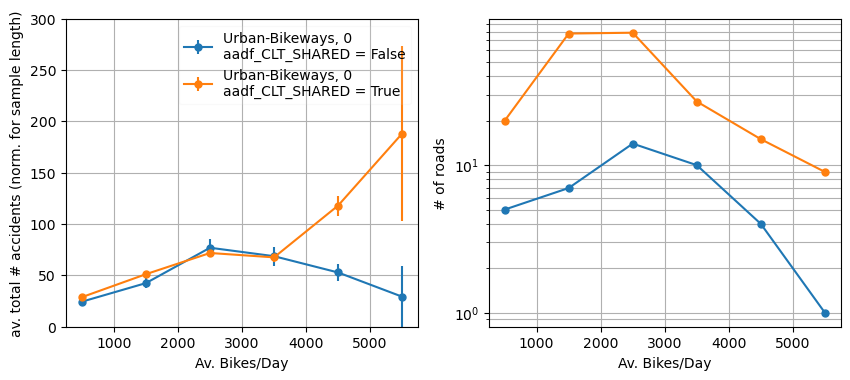

In [93]:
#Look at shared vs. unshared bikelanes in the urban group

group = 'Urban-Bikeways'
g_key = find_key(group_names,group)

f_class = 'aadf_CLT_SHARED'

dbv = 1000
bv_r = (0,6000)
e_bv,b_bv = make_bins(bv_r,dbv)
Nbv = len(b_bv)

fy = 'total_dnorm_LL'

H_tot_dnorm_bv = np.zeros((2,Nbv)) #first dimension is False or True for f_class
BoolVal = [False,True]
for ii in range(2):
    I = Igroup[g_key] & (df_cluster[f_class] == BoolVal[ii])
    H,_ = np.histogram(df_cluster.loc[I,'aadf_Pedal_cycles'],bins=e_bv)
    H_tot,_ = np.histogram(df_cluster.loc[I,'aadf_Pedal_cycles'],bins=e_bv,weights=df_cluster.loc[I,fy])
    H_tot_dnorm_bv[ii] = H_tot/H
    

#calculate errorbars

fbin = 'aadf_Pedal_cycles'
fquant = 'total'
fnorm = 'aadf_Link_length_miles'
Lmed = df_cluster.aadf_Link_length_miles.median()
H_err = np.zeros((2,Nbv))
N_err = np.zeros((2,Nbv))
for ii in range(2):
    Iselect = Igroup[g_key] & (df_cluster[f_class] == BoolVal[ii])
    for jj in range(Nbv):
        Ibin = logic_win(df_cluster[fbin].values,(e_bv[jj],e_bv[jj+1]))
        I = Ibin & Iselect
        N = I.sum()
        if N > 0: 
            N_err[ii,jj] = N
            quants = df_cluster.loc[I,fquant].values
            norms = df_cluster.loc[I,fnorm].values
            sig_norms = np.zeros(N)
            for kk in range(N):
                Iedge = e_LL >= norms[ii] #using e_LL from above in sigma calc
                if Iedge.sum() <= 1:
                    sig_norms[ii] = sigma_LL_urb[-1]
                else:
                    sig_norms[ii] = sigma_LL_urb[Iedge[:-1]][0]
            sig_quants = np.sqrt(quants)
            H_err[ii,jj] = Lmed/N*np.sqrt(np.sum( ((quants/norms)**2)*((sig_quants/quants)**2 +\
                                                                       (sig_norms/norms)**2 -\
                                                                       2*p_LL_tot_urb*sig_quants*sig_norms/(quants*norms)) ))

fig,ax = plt.subplots(1,2,figsize=(2*5,4))
labsize=10
ticksize=10
legsize=10
msize = 10
                      
nn = 0
for ii in range(2):
    ax[nn].errorbar(b_bv,H_tot_dnorm_bv[ii],H_err[ii],marker='.',
              label='%s, %i\n%s = %s'%(group,g_key,f_class,BoolVal[ii]),markersize=msize)
    
ax[nn].set_xlabel('Av. Bikes/Day',fontsize=labsize)
ax[nn].set_ylabel('av. total # accidents (norm. for sample length)',fontsize=labsize)
ax[nn].tick_params(labelsize=ticksize)
ax[nn].legend(fontsize=legsize,fancybox=True,framealpha=0.1)
ax[nn].set_ylim(0,300)
ax[nn].grid('on')


nn = 1
for ii in range(2):
    ax[nn].plot(b_bv,N_err[ii],marker='.',
              label='%s, %i\n%s = %s'%(group,g_key,f_class,BoolVal[ii]),markersize=msize)
    
ax[nn].set_xlabel('Av. Bikes/Day',fontsize=labsize)
ax[nn].set_ylabel('# of roads',fontsize=labsize)
ax[nn].tick_params(labelsize=ticksize)
#ax[nn].legend(fontsize=legsize)
#ax[nn].set_ylim(0,300)
ax[nn].set_yscale('log')
ax[nn].grid('on',which='both')

plt.show()                      

- what is with the diverging part between 4000 and 6000 bikes/day? The difference is in shared vs. unshared bikelanes.
- maybe make histograms with the same bins, but plot average bus traffic vs. av bikes/day


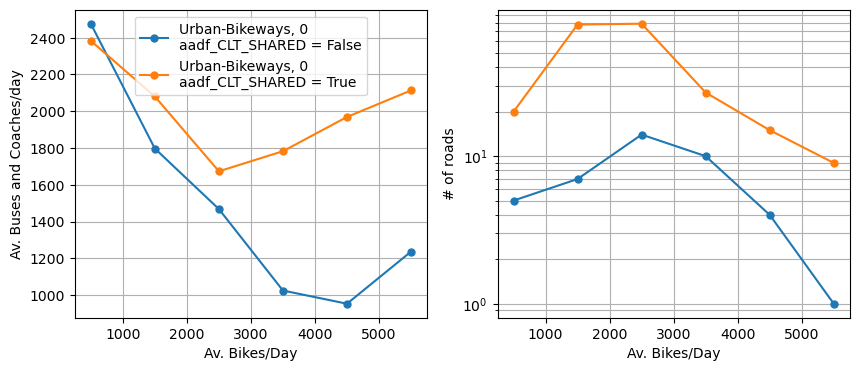

In [94]:
# dbv = 1000
# bv_r = (0,8000)
# e_bv,b_bv = make_bins(bv_r,dbv)
# Nbv = len(b_bv)

fy = 'aadf_Buses_and_coaches'

H_tot_dnorm_bv = np.zeros((2,Nbv)) #first dimension is False or True for f_class
BoolVal = [False,True]
for ii in range(2):
    I = Igroup[g_key] & (df_cluster[f_class] == BoolVal[ii])
    H,_ = np.histogram(df_cluster.loc[I,'aadf_Pedal_cycles'],bins=e_bv)
    H_tot,_ = np.histogram(df_cluster.loc[I,'aadf_Pedal_cycles'],bins=e_bv,weights=df_cluster.loc[I,fy])
    H_tot_dnorm_bv[ii] = H_tot/H
    
fig,ax = plt.subplots(1,2,figsize=(2*5,4))
labsize=10
ticksize=10
legsize=10
msize = 10
                      
nn = 0
for ii in range(2):
    ax[nn].plot(b_bv,H_tot_dnorm_bv[ii],marker='.',
              label='%s, %i\n%s = %s'%(group,g_key,f_class,BoolVal[ii]),markersize=msize)
    
ax[nn].set_xlabel('Av. Bikes/Day',fontsize=labsize)
ax[nn].set_ylabel('Av. Buses and Coaches/day',fontsize=labsize)
ax[nn].tick_params(labelsize=ticksize)
ax[nn].legend(fontsize=legsize)
#ax[nn].set_ylim(0,300)
ax[nn].grid('on')

nn = 1
for ii in range(2):
    ax[nn].plot(b_bv,N_err[ii],marker='.',
              label='%s, %i\n%s = %s'%(group,g_key,f_class,BoolVal[ii]),markersize=msize)
    
ax[nn].set_xlabel('Av. Bikes/Day',fontsize=labsize)
ax[nn].set_ylabel('# of roads',fontsize=labsize)
ax[nn].tick_params(labelsize=ticksize)
#ax[nn].legend(fontsize=legsize)
#ax[nn].set_ylim(0,300)
ax[nn].set_yscale('log')
ax[nn].grid('on',which='both')

plt.show()   

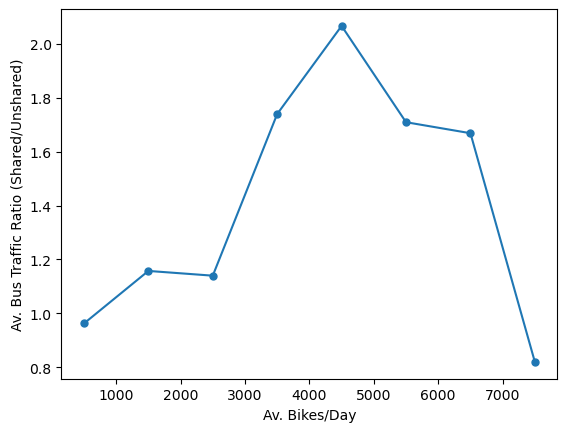

In [75]:
plt.plot(b_bv,H_tot_dnorm_bv[1]/H_tot_dnorm_bv[0],marker='.',markersize=10)
plt.xlabel('Av. Bikes/Day')
plt.ylabel('Av. Bus Traffic Ratio (Shared/Unshared)')

plt.show()

#### Distribution of link length for groups

In [87]:
df_cluster.aadf_Link_length_miles.describe()

count    1310.000000
mean        0.518998
std         0.488385
min         0.060000
25%         0.190000
50%         0.370000
75%         0.750000
max         3.230000
Name: aadf_Link_length_miles, dtype: float64

In [50]:
group_names

{0: 'Urban-Bikeways', 1: 'Suburban Roads', 2: 'Expressways'}

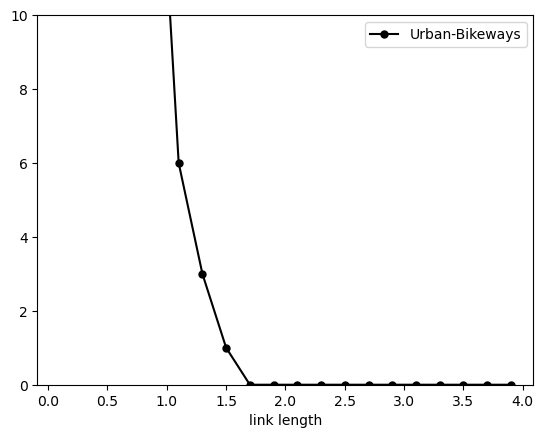

In [68]:
LL_r = (0,4)
dLL = 0.2
e_LL,b_LL = make_bins(LL_r,dLL)
Nb_LL = len(b_LL)

Iacc = df_cluster.total >= 10

H_LL = np.zeros((k,Nb_LL))
for ii in range(k):
    H_LL[ii],_ = np.histogram(df_cluster.loc[Igroup[ii]&Iacc,'aadf_Link_length_miles'],bins=e_LL)
    
fig,ax=plt.subplots()
for ii in [0]:
    ax.plot(b_LL,H_LL[ii],label=group_names[ii],color=group_c[ii],marker='.',markersize=10)
    
ax.set_xlabel('link length')
ax.set_ylim(0,10)
ax.legend()
plt.show()

In [23]:
#calculate averaged normalized total_dnorm_bvnorm
    #must use Link_length for dnorm
    
tot_dnorm_bvnorm_g = np.zeros(k)
tot_g = np.zeros(k)
LL_av_g = np.zeros(k)
BV_av_g = np.zeros(k)

LL_med = df_cluster.aadf_Link_length_miles.median()
BV_med = df_cluster.aadf_Pedal_cycles.median()
print('Normalized accident totals\n_______________')
for ii in range(k):
    tot_g[ii] = df_cluster.loc[Igroup[ii],'total'].sum()
    LL_av_g[ii] = df_cluster.loc[Igroup[ii],'aadf_Link_length_miles'].mean()
    BV_av_g[ii] = df_cluster.loc[Igroup[ii],'aadf_Pedal_cycles'].mean()
    
    tot_dnorm_bvnorm_g[ii] = tot_g[ii]*LL_med/LL_av_g[ii]*BV_med/BV_av_g[ii]
    print('Group %i norm. total = %.1f accidents'%(ii,tot_dnorm_bvnorm_g[ii]))
   
print('\nAverage aadf bike volume\n_______________')
for ii in range(k):
    print('Group %i av. bike vol = %.1f bikes/day'%(ii,BV_av_g[ii]))

Normalized accident totals
_______________
Group 0 norm. total = 1671.5 accidents
Group 1 norm. total = 8361.6 accidents
Group 2 norm. total = 385.9 accidents

Average aadf bike volume
_______________
Group 0 av. bike vol = 2425.4 bikes/day
Group 1 av. bike vol = 309.4 bikes/day
Group 2 av. bike vol = 47.0 bikes/day


### Export imputed Link_lengths from k = 3

In [22]:
#print average link length for each group
LL_av = np.zeros(k)
for ii in range(k):
    Iun = df_cluster.aadf_Link_length_miles == -9
    I = ~Iun & Igroup[ii]
    LL_av[ii] = df_cluster.loc[I,'aadf_Link_length_miles'].mean()
    print('group %i av. link length of %.2f miles'%(ii,LL_av[ii]))
    
LL_median = np.zeros(k)
print()
LL_av = np.zeros(k)
for ii in range(k):
    Iun = df_cluster.aadf_Link_length_miles == -9
    I = ~Iun & Igroup[ii]
    LL_median[ii] = df_cluster.loc[I,'aadf_Link_length_miles'].median()
    print('group %i av. link length of %.2f miles'%(ii,LL_median[ii]))

group 0 av. link length of 0.73 miles
group 1 av. link length of 1.35 miles
group 2 av. link length of 0.33 miles

group 0 av. link length of 0.50 miles
group 1 av. link length of 0.84 miles
group 2 av. link length of 0.25 miles


In [26]:
#make a dataframe with the Link_length or imputed Link_length of all IDs here

df_link_lengths = pd.DataFrame()
df_link_lengths['ID'] = df_cluster['ID'].values
df_link_lengths['Link_length_miles'] = df_cluster['aadf_Link_length_miles'].values
df_link_lengths['Imputed'] = (df_cluster.aadf_Link_length_miles == -9).values

#Iun = df_link_lengths['Link_length_miles'] == -9
for ii in range(k):
    I = df_link_lengths.Imputed & Igroup[ii]
    df_link_lengths.loc[I,'Link_length_miles'] = LL_median[ii]

In [27]:
df_link_lengths

,ID,Link_length_miles,Imputed
0,6201,0.930000,False
1,46277,0.620000,False
2,56108,0.990000,False
3,56175,0.990000,False
4,56771,1.300000,False
...,...,...,...
2114,27866,4.470000,False
2115,27883,5.280000,False
2116,27089,0.814286,False
2117,27923,1.860000,False


In [28]:
df_link_lengths.Imputed.sum()

0

In [21]:
path = '../Dataframes/Link_lengths_withImpute.csv'
df_link_lengths.to_csv(path,index_label=False)